In [10]:
import os
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../SpotWeb'))


import optimizationSimulator as ms
import optimizationPolicies as mp
import optimizationCosts as mc
import optimizationRisks as mr

In [11]:
%load_ext autoreload                              
#autoreload reloads modules automatically before entering the execution of code
%autoreload 2                                      
#autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%matplotlib inline                              
#Put the plots inline in the notebook
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx
from optimizationConstraints import MaxOP, MaxZ, MinZ, LongOnly
#from SpotWeb.utils import *


random.seed(0)

plotdir='../data/plots/'
datadir='../data/' 

consideredInstances=['m4.large', 'm4.xlarge', 'm4.2xlarge', 'r4.large','c5d.9xlarge',
                     'r4.xlarge', 'r4.2xlarge', 'r4.4xlarge', 'r4.8xlarge',  'r5.large',
                      'r5.2xlarge', 'r5.4xlarge', 'r5.8xlarge', 'r5.12xlarge', 'r5.16xlarge', 'r5.24xlarge', 
                     'r5d.large','r5d.xlarge', 'r5d.2xlarge', 'r5d.4xlarge', 'r5d.8xlarge', 'r5d.12xlarge', 
                     'r5d.16xlarge', 'r4.xlarge','m4.10xlarge', 'r4.4xlarge', 'r4.xlarge', 'r4.2xlarge', 'r4.4xlarge',
                     'r4.8xlarge', 'r4.16xlarge', 'r5.large', 'r5.xlarge',
                      'r5.2xlarge', 'r5.4xlarge', 'r5.8xlarge', 'r5.12xlarge', 'r5.16xlarge', 'r5.24xlarge', 'r5d.large',
                     'r5d.xlarge', 'r5d.2xlarge', 'r5d.4xlarge', 'r5d.8xlarge', 'r5d.12xlarge', 'r5d.16xlarge',
                      'r5d.24xlarge', 'x1.16xlarge', 'x1.32xlarge',  'c4.large', 'c4.xlarge', 'c4.2xlarge', 'c4.4xlarge',
                      'c4.8xlarge', 'c5.large', 'c5.xlarge', 'c5.2xlarge', 'c5.4xlarge', 'c5.9xlarge', 'c5.18xlarge',
                      'c5d.large', 'c5d.xlarge', 'c5d.2xlarge', 'c5d.4xlarge', 'c5d.9xlarge', 'c5d.18xlarge', 'm5.large',
                     'm5.xlarge', 'm5.2xlarge', 'm5.4xlarge', 'm5.12xlarge', 'm5.24xlarge', 'm5d.large', 'm5d.xlarge',
                     'm5d.2xlarge', 'm5d.4xlarge', 'm5d.12xlarge', 'm5d.24xlarge']


                        
# Workload setup for the simulation
start_t=pd.Timestamp(2008,5,17,10).tz_localize('UTC')      #Wikipedia workload timespan (or generally the workload timestart)
end_t=pd.Timestamp(2013,10,16,16).tz_localize('UTC')

L=np.linspace(0,1,21)

#sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]  
#returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
priceReq=pd.read_csv('../data/CurrentPricePerReq.csv',index_col=0,parse_dates=[0])

filteredPriceReq=pd.DataFrame(index=priceReq.index)
multiPrice=[]

for i in consideredInstances:
    if i in priceReq.columns:
        filteredPriceReq[i]=priceReq[i]



#filteredPriceReq.replace(0,1000000,inplace=True)
covariance=filteredPriceReq.corr()
covariance=covariance.T.dot(covariance)

print(covariance.columns)
consideredInstances=covariance.columns.tolist()
print(consideredInstances, len(consideredInstances))

print(filteredPriceReq)
Lambda=pd.read_csv(datadir+'AggReq.out',index_col=0,parse_dates=[0],names=['time','Requests'], nrows=len(filteredPriceReq.index),skiprows=range(337))  
Lambda.index=filteredPriceReq.index
print(Lambda.index)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['m4.2xlarge', 'c5d.9xlarge', 'r4.xlarge', 'r4.2xlarge', 'r4.4xlarge',
       'r4.8xlarge', 'r5.2xlarge', 'r5.4xlarge', 'r5d.xlarge', 'r5d.4xlarge',
       'm4.10xlarge', 'r4.16xlarge', 'r5.xlarge', 'r5d.24xlarge',
       'x1.16xlarge', 'c4.2xlarge', 'c4.4xlarge', 'c4.8xlarge', 'c5.large',
       'c5.xlarge', 'c5.2xlarge', 'c5.4xlarge', 'c5.9xlarge', 'c5d.xlarge',
       'c5d.2xlarge', 'c5d.4xlarge', 'm5.xlarge', 'm5.2xlarge', 'm5.4xlarge',
       'm5.12xlarge', 'm5d.xlarge', 'm5d.2xlarge', 'm5d.4xlarge',
       'm5d.12xlarge'],
      dtype='object')
['m4.2xlarge', 'c5d.9xlarge', 'r4.xlarge', 'r4.2xlarge', 'r4.4xlarge', 'r4.8xlarge', 'r5.2xlarge', 'r5.4xlarge', 'r5d.xlarge', 'r5d.4xlarge', 'm4.10xlarge', 'r4.16xlarge', 'r5.xlarge', 'r5d.24xlarge', 'x1.16xlarge', 'c4.2xlarge', 'c4.4xlarge', 'c4.8xlarge', 'c5.large', 'c5.xlarge', 'c5.2xlarge', 'c5.4xlarge', 'c5.9xlarge', 'c5d.xlarge', 'c5d.2xlar

In [12]:
import cvxpy
print(cvxpy.__version__)

failureP=pd.read_csv('../data/failureProbaility.csv',parse_dates=[0])#.iloc[:65]
#print failureP.all
failureP.index=filteredPriceReq.index

#print failureP.all

filteredfailures=pd.DataFrame(index=filteredPriceReq.index)
print(filteredfailures.size)

for i in consideredInstances:
    if i in failureP.columns:
        filteredfailures[i]=failureP[i]
#print filteredfailures.all
print("Number of instances:", len(filteredfailures.columns))


price=pd.read_csv("../data/FullCurrentPrice.csv",index_col=0,parse_dates=[0],skiprows=range(1000))
filteredprice=pd.DataFrame(index=price.index)
for i in consideredInstances:
    if i in price.columns:
        filteredprice[i]=price[i]

print(len(filteredfailures))
iportfolio= [random.choice(range(5)) for i in range(len(filteredfailures.columns))]
initialportfolio=dict(zip(covariance.columns,[random.choice(range(2)) for i in range(len(filteredfailures))])) #A_0 in my equations
w_b = pd.Series(index=consideredInstances, data=1)   #A pandas Series is created with all values=1 and an index with all Machine types considered in SpotWeb.

w_b/=sum(w_b)          #Summed the series and divided each element by the sum (so all are  still equal)

start_t=pd.Timestamp(2018,1,25,17).tz_localize('UTC')
end_t=pd.Timestamp(2018,12,28,9).tz_localize('UTC')

for r in consideredInstances:
    filteredfailures.loc[:,r]=0.05

print(Lambda.index, filteredfailures.index, filteredPriceReq.index)
#simulated_tcost = mc.TcostModelServers(arrival=Lambda, pricePerReq=filteredPriceReq) 
simulated_hcost = mc.HcostModelServers(penalty=0.02,L=0.02, pricePerReq=filteredPriceReq,  probFail=filteredfailures,arrivalRate=Lambda)   #The penalty and L changes for different simulation runs
print(type(simulated_hcost))
print(isinstance(simulated_hcost, mc.HcostModelServers))
simulator = ms.MarketSimulator(costs=[simulated_hcost],failures=filteredfailures)    #This is the initialization of the simulator platform


# Can be used to change the simulated costs versus the real costs  simulated values as we are assuming an oracle for now
#optimization_tcost = mc.TcostModelServers(arrival=Lambda, pricePerReq=filteredPriceReq)                           
optimization_hcost=mc.HcostModelServers(penalty=0.02,L=0.02, pricePerReq=filteredPriceReq, probFail=filteredfailures,arrivalRate=Lambda)
risk_model = mr.FullSigma(Sigma=covariance)

results={}   #The results dictionary


1.4.1
0
Number of instances: 34
1465
DatetimeIndex(['2018-09-06 17:00:00+00:00', '2018-09-19 23:00:00+00:00',
               '2018-09-20 22:00:00+00:00', '2018-09-27 21:00:00+00:00',
               '2018-09-27 22:00:00+00:00', '2018-09-28 00:00:00+00:00',
               '2018-09-28 02:00:00+00:00', '2018-09-28 03:00:00+00:00',
               '2018-09-28 04:00:00+00:00', '2018-09-28 05:00:00+00:00',
               ...
               '2018-11-27 12:00:00+00:00', '2018-11-27 13:00:00+00:00',
               '2018-11-27 14:00:00+00:00', '2018-11-27 15:00:00+00:00',
               '2018-11-27 16:00:00+00:00', '2018-11-27 17:00:00+00:00',
               '2018-11-27 18:00:00+00:00', '2018-11-27 19:00:00+00:00',
               '2018-11-27 20:00:00+00:00', '2018-11-27 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1465, freq=None) DatetimeIndex(['2018-09-06 17:00:00+00:00', '2018-09-19 23:00:00+00:00',
               '2018-09-20 22:00:00+00:00', '2018-09-27 21:00:00+00:00',


In [13]:
results_MPO={}

# MPO search

In [14]:
%%capture cap --no-stderr

import pickle

policies={}

gamma_risks_coarse=[5,50,100]
lookahead=[1,2,4]#,5,6]
accuracy=[0.01,] #0.03, 0.05, 0.1,0.2,0.5,1] 

# We can simulate for different gammas 
# for g in gamma_risks_coarse:
for lookahead_period in lookahead:
        #print lookahead_period
        for acc in accuracy:
            print(acc)
            policies[lookahead_period,acc] = mp.MultiPeriodOpt(costs=[5*risk_model, optimization_hcost], 
                          constraints=[MaxOP(),LongOnly(),MinZ(),MaxZ()],
                          trading_times=list(filteredPriceReq.index[(filteredPriceReq.index>=start_t)&
                          (filteredPriceReq.index<=end_t)]), lookahead_periods=lookahead_period,)#accuracy=acc)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=False))})




C:\Users\Dominik\AppData\Roaming\Python\Python310\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10249 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Dominik\AppData\Roaming\Python\Python310\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10250 times so far.

  wa

KeyboardInterrupt: 

In [ ]:
with open('RealExp.txt', 'w') as f:
    f.write(cap.stdout)

print(results_MPO.keys())
with open("RealExp.pickle","wb") as pickle_out:
    pickle.dump(results_MPO, pickle_out)


dict_keys([(1, 0.01), (2, 0.01), (4, 0.01)])


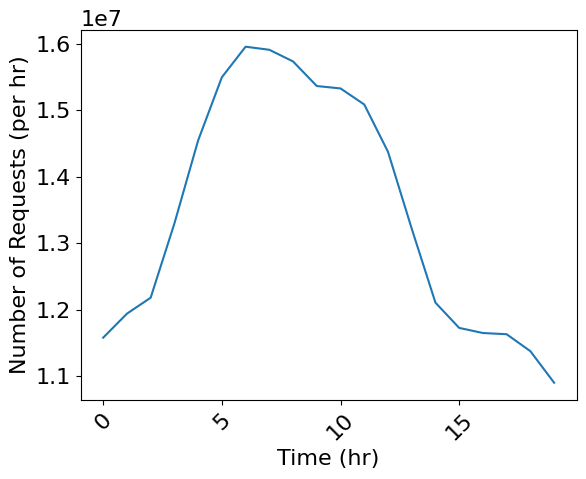

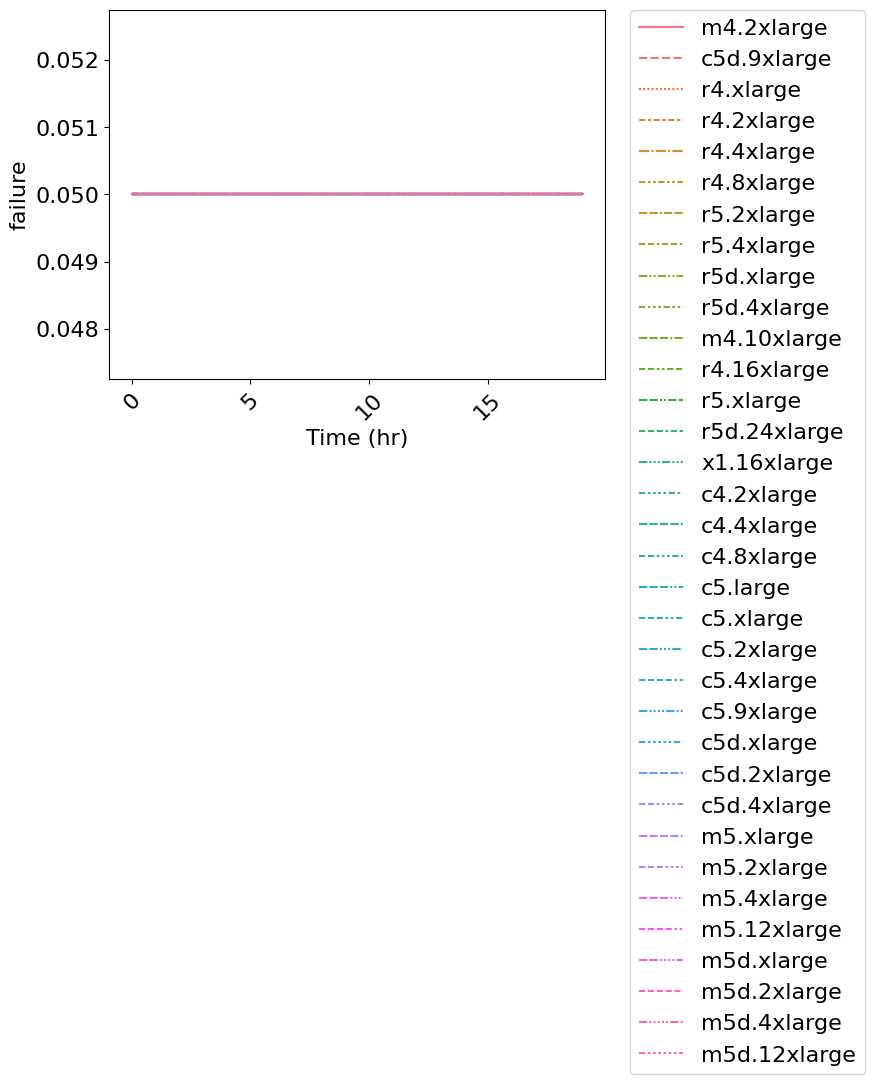

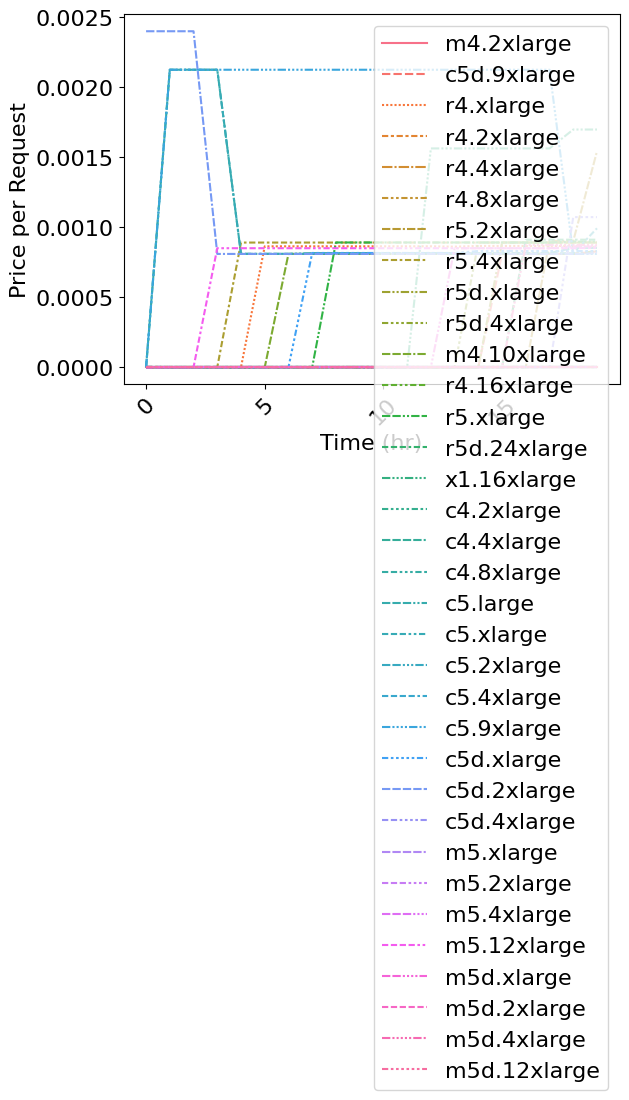

C:\Users\Dominik\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Number of periods                                                            1465
Initial timestamp                                       2018-09-06 17:00:00+00:00
Final timestamp                                         2018-11-27 21:00:00+00:00
Portfolio return (%)                                                        0.000
Excess return (%)               2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Excess risk (%)                 2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Sharpe ratio                    2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Max. drawdown                                                               0.008
Average policy time (sec)                                                   0.098
Average simulator time (sec)                                                0.005


C:\Users\Dominik\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Number of periods                                                            1465
Initial timestamp                                       2018-09-06 17:00:00+00:00
Final timestamp                                         2018-11-27 21:00:00+00:00
Portfolio return (%)                                                        0.000
Excess return (%)               2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Excess risk (%)                 2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Sharpe ratio                    2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Max. drawdown                                                               0.008
Average policy time (sec)                                                   0.200
Average simulator time (sec)                                                0.005


C:\Users\Dominik\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Number of periods                                                            1465
Initial timestamp                                       2018-09-06 17:00:00+00:00
Final timestamp                                         2018-11-27 21:00:00+00:00
Portfolio return (%)                                                        0.000
Excess return (%)               2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Excess risk (%)                 2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Sharpe ratio                    2018-09-06 17:00:00+00:00    NaN
2018-09-19 23...
Max. drawdown                                                               0.008
Average policy time (sec)                                                   0.442
Average simulator time (sec)                                                0.005
['m4.2xlarge', 'c5d.9xlarge', 'r4.xlarge', 'r4.2xlarge', 'r4.4xlarge', 'r4.8xlarge', 'r5.2xlarge', 'r5.4xlarge', 'r5d.xlarge', 'r5d.4xlarge', 'm4.10xlarge', 'r4.16xlarge', 'r5.xlar

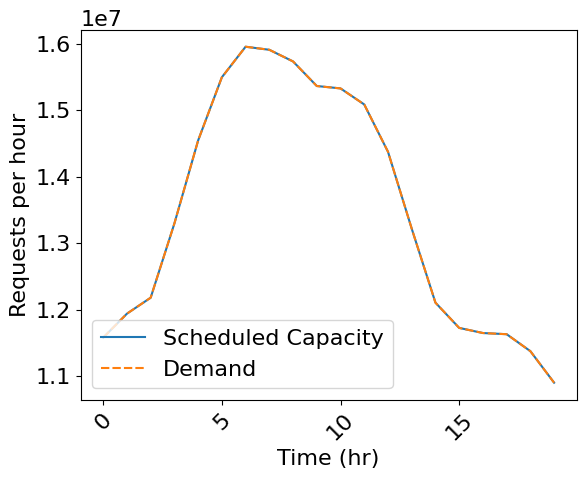

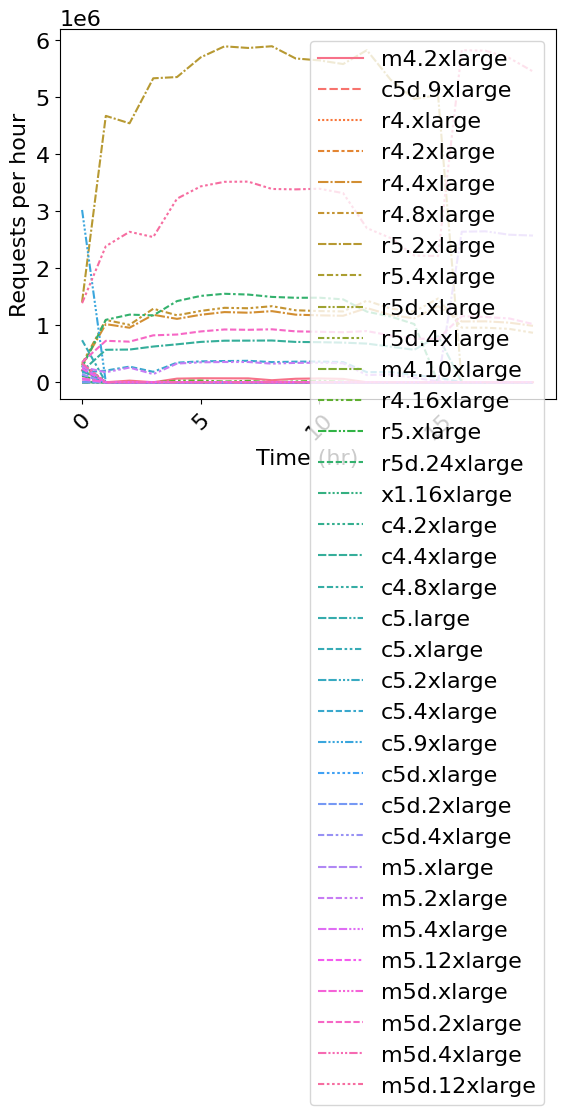

576000
2592000
288000
576000
1152000
2304000
576000
1152000
288000
1152000
2880000
4608000
288000
6912000
4608000
576000
1152000
2592000
144000
288000
576000
1152000
2592000
288000
576000
1152000
288000
576000
1152000
3456000
288000
576000
1152000
3456000


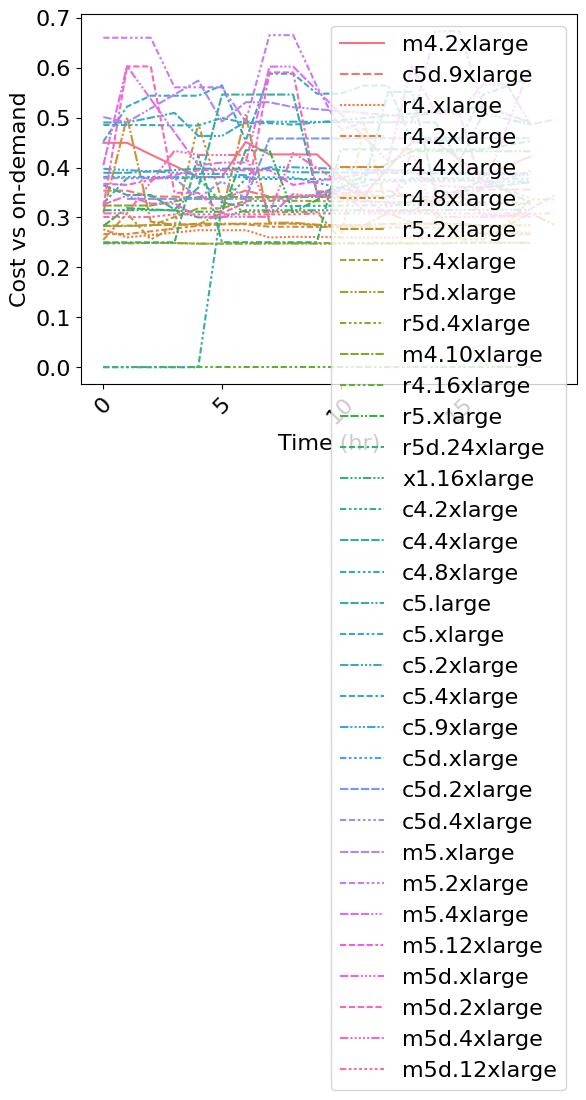

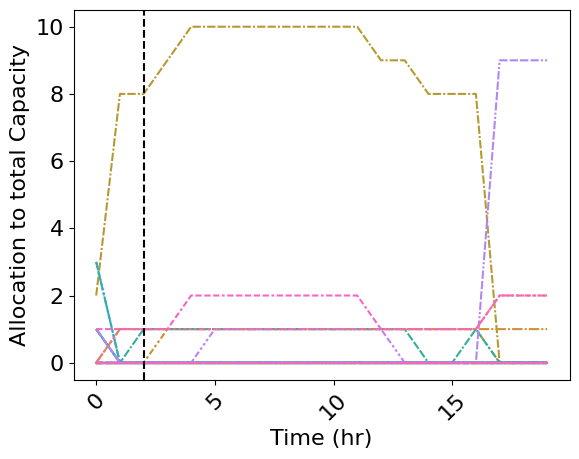

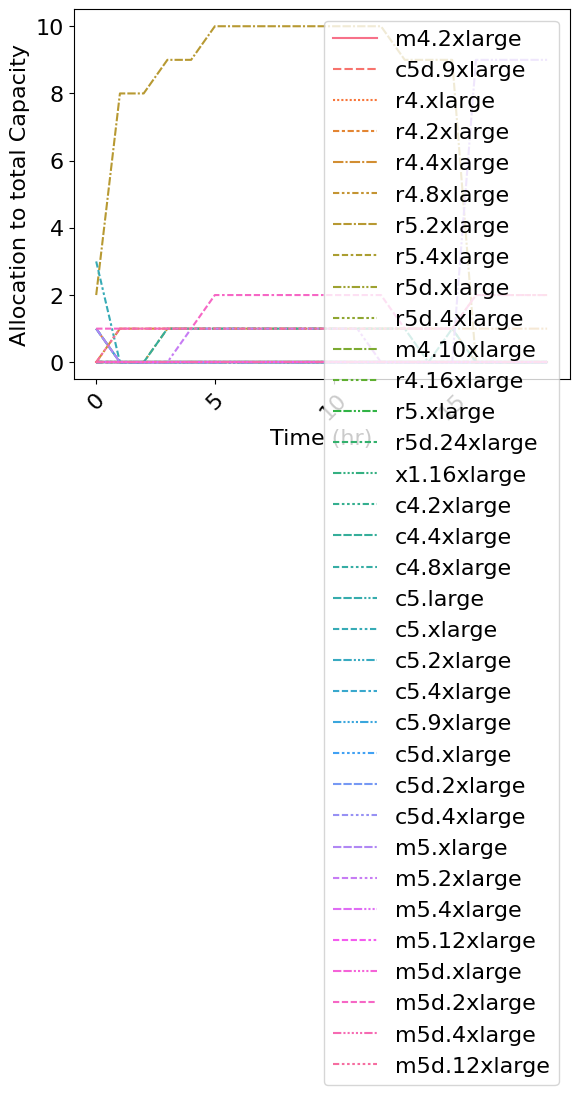

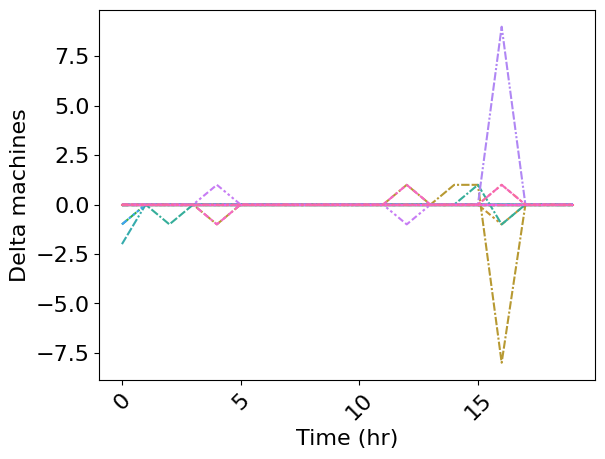

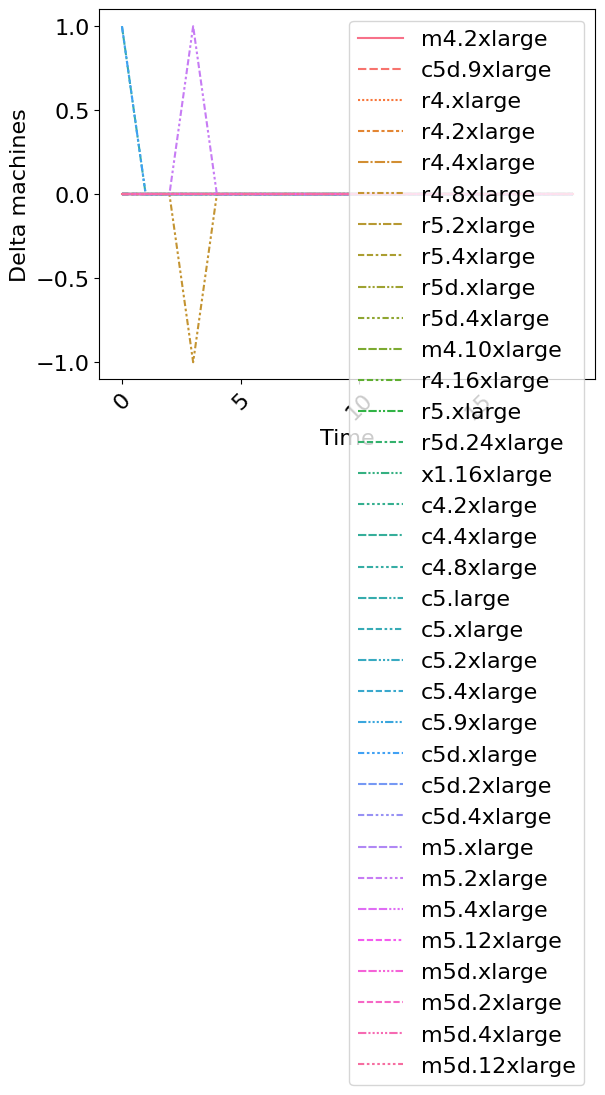

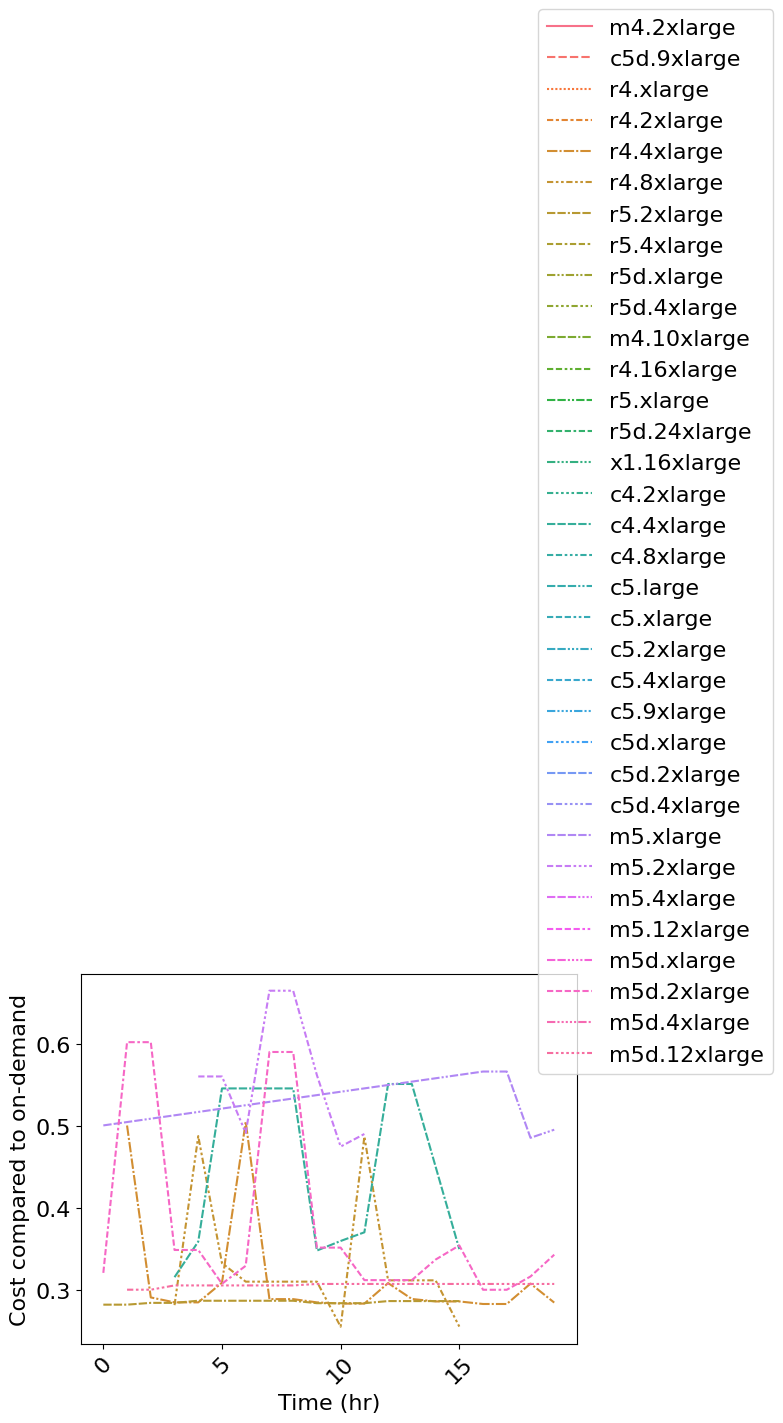

0.3232753500981499
0.32604163335784864
1.0009213500793734


In [19]:
import seaborn as sns
import matplotlib
import pickle
matplotlib.rcParams.update({'font.size': 16})



objects = []
with (open("RealExp.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
results_MPO=objects[0]
#print results_MPO.keys()
#start_t=pd.Timestamp(2018,9,22,0)
filteredfailures.index=range(filteredfailures.shape[0])
Lambda.index=range(Lambda.size)
filteredPriceReq.index=range(filteredPriceReq.shape[0])

data=Lambda.iloc[:20]
#data=data.iloc[48:96]
fig, ax = plt.subplots()
s=sns.lineplot(data=data,ax=ax)
ax.legend_.remove()
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Number of Requests (per hr)")
plt.savefig("../data/AutoscalingonlyWiki.pdf", bbox_inches='tight')
plt.show()
plt.close()

data=filteredfailures.iloc[:20]
#data=data.iloc[48:96]
s=sns.lineplot(data=data)
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("failure")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../data/Zoomedfailures.pdf", bbox_inches='tight')
plt.show()
plt.close()

rdata=filteredPriceReq.iloc[:20]
fig, ax = plt.subplots()
g=sns.lineplot(data=rdata,ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Price per Request")
plt.savefig("../data/AutoscalingZoomedPricePerReq.pdf", bbox_inches='tight')
plt.show()
plt.close()

u1=results_MPO[(1, 0.01)].u
for k in results_MPO:
   #if k in lookahead:
    results_MPO[k].summary()
    c=results_MPO[k].simulator_HcostModelServers.to_dict()
    l=[]
    for j in c:
        l+=c[j].values()
    l = [item for item in l if item >= 0]
        
#result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]
u1=results_MPO[(1, 0.01)].u
u2=results_MPO[(2, 0.01)].u
u4=results_MPO[(4, 0.01)].u
#u6=results_MPO[(6, 0.01)].u
#u10=results_MPO[(10, 0.01)].u

u1.index=range(u1.shape[0])
u2.index=range(u2.shape[0])
u4.index=range(u4.shape[0])

#onDemandPrice={'r4.4xlarge':1.064,'r5d.24xlarge':6.912,'r5.4xlarge':1.008}
onDemandPrice={'m4.2xlarge':0.40 ,'c5d.9xlarge':1.728,'r4.xlarge':0.266 ,
               'r4.2xlarge':0.532,'r4.4xlarge':1.064,'r4.8xlarge':2.128,
                'r5d.xlarge':0.288, 'm5d.4xlarge':0.904, 'm5.xlarge':0.192, 
               'r4.16xlarge':4.256, 'c5d.xlarge':0.192, 'r5d.4xlarge':1.152, 
               'x1.16xlarge':6.669, 'r4.4xlarge':1.064, 'c5d.2xlarge':0.384, 
               'r5.xlarge':0.252, 'c4.8xlarge':1.591, 'r4.8xlarge':2.128,
               'm5d.12xlarge':2.712, 'c5.4xlarge':0.68, 'c5.large':0.085, 
               'm5.2xlarge':0.384, 'c5.2xlarge':0.34, 'c4.4xlarge':0.796, 
               'r5.4xlarge':1.008, 'm5.4xlarge':0.768, 'm5d.xlarge':0.226, 
               'c5d.9xlarge':1.728 , 'c4.2xlarge':0.398, 'c5.xlarge':0.17,
               'c5d.4xlarge':0.768, 'c5.9xlarge':1.53, 'r5d.24xlarge':6.912,
               'm5.12xlarge':2.304, 'm5d.2xlarge':0.452, 'r5.2xlarge':0.504,
              'm4.10xlarge':2, 'm4.16xlarge':3.2, 'm4.4xlarge':0.80}

capacity=pd.read_csv("../data/requestsCapacity.csv",index_col=0)
servers=u1.columns.tolist()
print(servers)
capacity=capacity.loc[servers]
# print capacity
capacity*=3600
#price=price.loc[servers]
price=pd.read_csv("../data/FullCurrentPrice.csv",index_col=0,parse_dates=[0])
price= price.iloc[500:565]
price=price[servers]
price.index=range(price.shape[0])
#pricediv=price/onDemandPrice
#print price

onDemandPrice = {k: v for k, v in onDemandPrice.items() if k in price.columns}

u1[u1 < 0] = 0
u2[u2 < 0] = 0
u4[u4 < 0] = 0
#u6[u6 < 0] = 0
#u10[u10 < 0] = 0

#print u1
Lambda=Lambda.iloc[:20]

u2t = u2.T
scheduledCapacity = u2t.sum()
demand = Lambda.iloc[:20]['Requests']
data = pd.DataFrame({'Scheduled Capacity': scheduledCapacity.multiply(demand).values, 'Demand': demand}, index=scheduledCapacity.index)
fig, ax = plt.subplots()
g=sns.lineplot(data=data,ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Requests per hour")
plt.show()
plt.close()

#print Lambda
#print u1, Lambda.Requests
u2=u2.multiply(Lambda['Requests'],axis='index')
u1=u1.multiply(Lambda['Requests'],axis='index')
u4=u4.multiply(Lambda['Requests'],axis='index')

fig, ax = plt.subplots()
g=sns.lineplot(data=u2,ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Requests per hour")
plt.show()
plt.close()


for s in servers:
    #print u2[s]
    print(capacity.loc[s].tolist()[0])
    u1[s]=u1[s]/capacity.loc[s].tolist()[0]
    u2[s]=u2[s]/capacity.loc[s].tolist()[0]
    u4[s]=u4[s]/capacity.loc[s].tolist()[0]

fig, ax = plt.subplots()
g=sns.lineplot(data=(u2.multiply(price)).div(u2.multiply(onDemandPrice)),ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Cost vs on-demand")
plt.show()
plt.close()

# u1.index=range(85)
# u2.index=range(85)
# u4.index=range(85)
# print u1
    
u2= u2.round().iloc[:20].round()
u1=u1.round().iloc[:20].round()
u4=u4.round().iloc[:20].round()

fig, ax = plt.subplots()
g=sns.lineplot(data=u1,ax=ax)
ax.legend_.remove()
plt.axvline(x=2, color='k', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Allocation to total Capacity")
plt.savefig("AutoScalingOnlyZoomedAllocSPO.pdf", bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
g=sns.lineplot(data=u2,ax=ax)
#ax.get_legend().remove()
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Allocation to total Capacity")
plt.savefig("AutoScalingOnlyZoomedAllocMPO.pdf", bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
g=sns.lineplot(data=u2-u1,ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
plt.xlabel("Time (hr)")
plt.ylabel("Delta machines")
plt.savefig("AutoScalingOnlyZoomedAllocDiff.pdf", bbox_inches='tight')
plt.show()
plt.close()

g=sns.lineplot(data=u4-u2)
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Delta machines")
plt.savefig("ZoomedAlloc_Look1_0_3.pdf", bbox_inches='tight')
plt.show()
plt.close()

onDemandPrice = {k: v for k, v in onDemandPrice.items() if k in price.columns}

fig, ax = plt.subplots()
g=sns.lineplot(data=(u2.multiply(price)).div(u2.multiply(onDemandPrice)),ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(0.9, 0.7))
plt.xlabel("Time (hr)")
plt.ylabel("Cost compared to on-demand")
plt.savefig("ِAutoScalingOnlyZoomedCostReductionToOnDemand.pdf", bbox_inches='tight')
plt.show()
plt.close()

print(u1.multiply(price).fillna(0).values.sum()/ u1.multiply(onDemandPrice).fillna(0).values.sum())
print(u2.multiply(price).fillna(0).values.sum()/ u2.multiply(onDemandPrice).fillna(0).values.sum())
print(u2.multiply(price).fillna(0).values.sum()/ u1.multiply(price).fillna(0).values.sum())

# g=sns.lineplot(data=u4)
# plt.xticks(rotation=45)
# plt.xlabel("Time")
# plt.ylabel("Allocation to total Capacity")
# plt.savefig("ZoomedAlloc_Look1_0_3.pdf", bbox_inches='tight')
# plt.show()
# plt.close()


In [ ]:
print(policies.keys())
result_df_coarse=pd.DataFrame()
if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
       result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

dict_keys([(1, 0.01), (2, 0.01), (4, 0.01)])
